In [1]:
!pip install pyspellchecker textblob pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 16.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from textblob import TextBlob
from spellchecker import SpellChecker
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import random
from gensim.models import Word2Vec
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import math
import torch
from torch.utils.data import TensorDataset, DataLoader

import torch.nn as nn
import torch.optim as optim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc




### Loading Dataset

In [3]:
dataset_train = pd.read_csv('train.csv', header = None)
dataset_test = pd.read_csv('test.csv', header = None)

In [4]:
df = pd.concat([dataset_train, dataset_test], ignore_index = True)

In [5]:
df.columns = ['class', 'title', 'description']

### Statistics of the dataset

In [6]:
print(f'Shape of the dataset: {df.shape}')

Shape of the dataset: (127600, 3)


In [7]:
df.isnull().sum()

class          0
title          0
description    0
dtype: int64

In [8]:
df['class'].value_counts()

class
3    31900
4    31900
2    31900
1    31900
Name: count, dtype: int64

In [9]:
df['title'].apply(lambda x: len(x.split())).describe()

count    127600.000000
mean          6.783229
std           2.088456
min           1.000000
25%           5.000000
50%           7.000000
75%           8.000000
max          19.000000
Name: title, dtype: float64

In [10]:
df['description'].apply(lambda x: len(x.split())).describe()


count    127600.000000
mean         31.056771
std           9.759814
min           3.000000
25%          25.000000
50%          30.000000
75%          36.000000
max         173.000000
Name: description, dtype: float64

### Visualizations

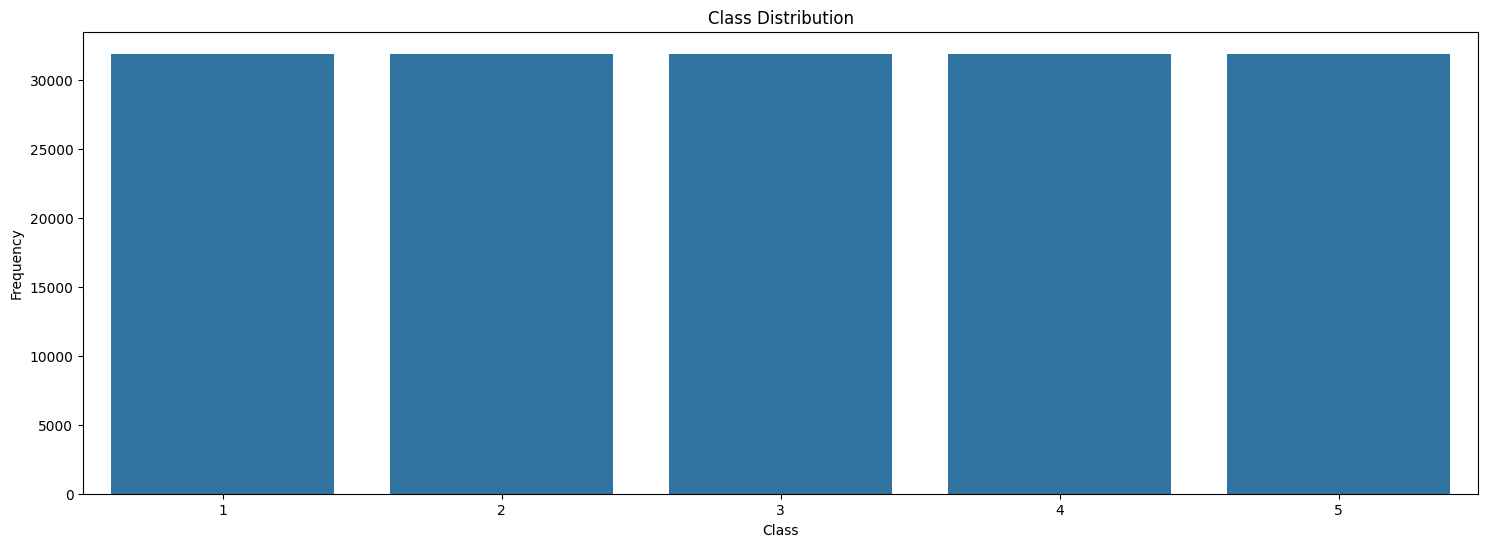

In [11]:
class_counts = pd.Series([31900, 31900, 31900, 31900, 31900], index=[1, 2, 3, 4, 5])

title_word_count = np.random.normal(loc=6.78, scale=2.08, size=127600)

description_word_count = np.random.normal(loc=31.05, scale=9.75, size=127600)

plt.figure(figsize=(18, 6))


sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')


plt.show()


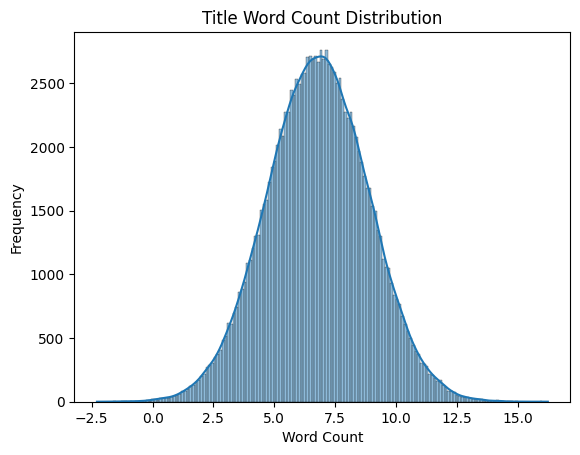

In [12]:
sns.histplot(title_word_count, kde=True)
plt.title('Title Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


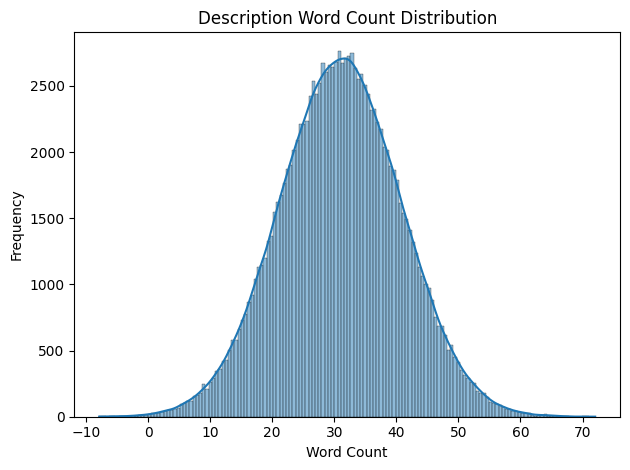

In [13]:
sns.histplot(description_word_count, kde=True)
plt.title('Description Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

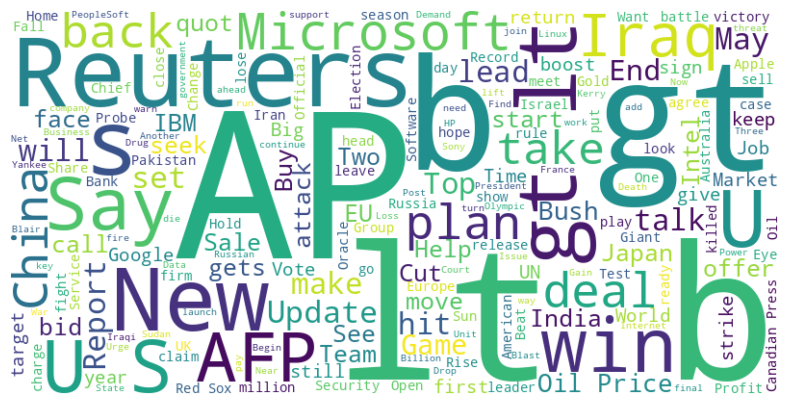

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

txt = ' '.join(df['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white')

wordcloud.generate(txt)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


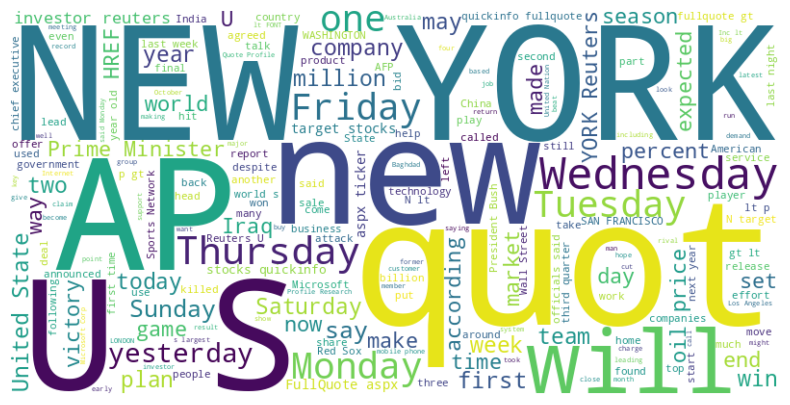

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

txt = ' '.join(df['description'])
wordcloud = WordCloud(width=800, height=400, background_color='white')

wordcloud.generate(txt)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


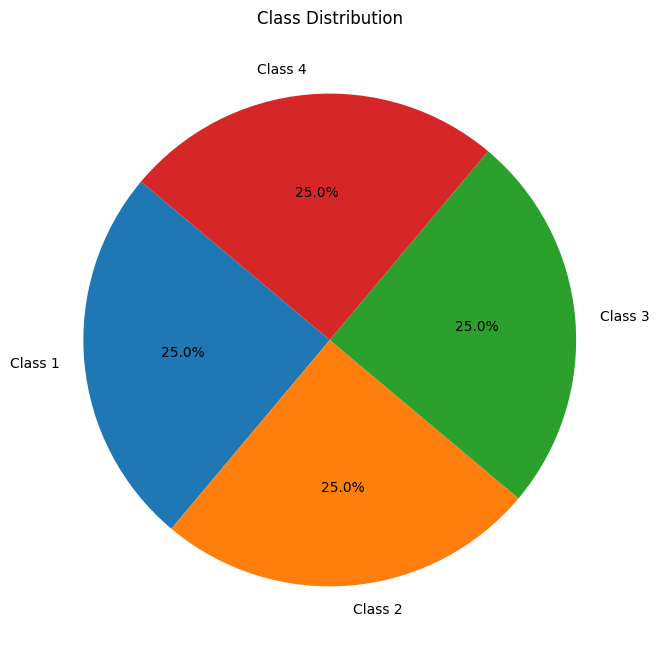

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

class_distribution = df['class'].value_counts().sort_index()
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4']
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_labels, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.show()


### Removing Punctuation


In [17]:
df['title'] = df['title'].str.lower()


In [18]:
df['description'] = df['description'].str.lower()

In [19]:
df.head()

class                                              title  \
0      3  wall st. bears claw back into the black (reuters)   
1      3  carlyle looks toward commercial aerospace (reu...   
2      3    oil and economy cloud stocks' outlook (reuters)   
3      3  iraq halts oil exports from main southern pipe...   
4      3  oil prices soar to all-time record, posing new...   

                                         description  
0  reuters - short-sellers, wall street's dwindli...  
1  reuters - private investment firm carlyle grou...  
2  reuters - soaring crude prices plus worries\ab...  
3  reuters - authorities have halted oil export\f...  
4  afp - tearaway world oil prices, toppling reco...

In [20]:
def deletePunc(text):
    return text.translate(str.maketrans('', '', string.punctuation))


In [21]:
df['title'] = df['title'].apply(deletePunc)

In [22]:
df['description'] = df['description'].apply(deletePunc)

### Stop Word Removal

In [23]:
import nltk
nltk.download('stopwords')

cachedStopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
def removeStopWords(text):
    # Using a list comprehension for efficiency
    filtered_words = [word for word in text.split() if word not in cachedStopwords]
    # Joining the filtered words back into a string
    return ' '.join(filtered_words)

In [25]:
df['title'] = df['title'].apply(removeStopWords)
df['description'] = df['description'].apply(removeStopWords)

In [26]:
df.head()

class                                              title  \
0      3              wall st bears claw back black reuters   
1      3  carlyle looks toward commercial aerospace reuters   
2      3           oil economy cloud stocks outlook reuters   
3      3  iraq halts oil exports main southern pipeline ...   
4      3  oil prices soar alltime record posing new mena...   

                                         description  
0  reuters shortsellers wall streets dwindlingban...  
1  reuters private investment firm carlyle groupw...  
2  reuters soaring crude prices plus worriesabout...  
3  reuters authorities halted oil exportflows mai...  
4  afp tearaway world oil prices toppling records...

### Spelling Check

In [27]:
spell = SpellChecker()

def removeWronglyWords(text):
  return ' '.join([word for word in text.split() if word in spell])

In [28]:
df['title'] = df['title'].apply(removeWronglyWords)

In [29]:
df['description'] = df['description'].apply(removeWronglyWords)

### Removing numbers

In [30]:
def removeNumber(text):
  return text.replace(r'\d+', '')


In [31]:
df['title'] = df['title'].apply(removeNumber)

In [32]:

df['description'] = df['description'].apply(removeNumber)

In [33]:
df.head()

class                                              title  \
0      3                         wall bears claw back black   
1      3                  looks toward commercial aerospace   
2      3                   oil economy cloud stocks outlook   
3      3      iraq halts oil exports main southern pipeline   
4      3  oil prices soar record posing new menace us ec...   

                                         description  
0                          wall streets seeing green  
1  private investment firm reputation making play...  
2  soaring crude prices plus economy outlook earn...  
3  authorities halted oil main pipeline southern ...  
4  tearaway world oil prices toppling records str...

### Lemmatization

In [34]:

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [35]:
def lemma(text):
  return ' '.join([WordNetLemmatizer().lemmatize(word, pos= 'n') for word in text.split()])

In [36]:
df['description'] = df['description'].apply(lemma)


In [37]:
df['title'] = df['title'].apply(lemma)

In [38]:
df.head()

class                                              title  \
0      3                          wall bear claw back black   
1      3                   look toward commercial aerospace   
2      3                    oil economy cloud stock outlook   
3      3        iraq halt oil export main southern pipeline   
4      3  oil price soar record posing new menace u economy   

                                         description  
0                           wall street seeing green  
1  private investment firm reputation making play...  
2  soaring crude price plus economy outlook earni...  
3  authority halted oil main pipeline southern ir...  
4  tearaway world oil price toppling record strai...

### Vectorization

In [39]:
w = Word2Vec(df['title'], vector_size=250, workers=4)

In [40]:
def vectorize_sentence(w, sentence):
    if not sentence:
        return np.zeros(w.vector_size)
    return sum(w.wv[word] for word in sentence if word in w.wv) / len(sentence)


In [41]:
word2vec = []
for i in df['title']:
    word2vec.append(vectorize_sentence(w, i))

In [42]:
a = np.array(word2vec)

In [43]:
word2vec

[array([ 8.98259412e-03,  8.84311870e-02, -1.59184095e-02, -2.28133202e-02,
        -1.09500624e-01, -1.86195616e-02,  3.28724086e-02,  1.18700601e-02,
        -9.27354954e-03, -1.49313072e-02,  2.30329521e-02,  1.00217797e-01,
         5.82600245e-03, -4.59695533e-02,  2.62979791e-02,  1.78564172e-02,
         5.32523058e-02, -7.98883140e-02,  1.95643026e-02, -1.10166982e-01,
        -3.75186391e-02, -1.45858238e-02, -9.65234861e-02,  5.42780124e-02,
         3.81859355e-02,  5.05479798e-03, -5.98708726e-02,  5.47216497e-02,
         7.38270804e-02,  3.73851806e-02,  9.41865817e-02, -4.60730046e-02,
        -3.67199406e-02, -8.71863775e-03,  1.42252743e-02,  1.81945920e-01,
         6.48594797e-02, -4.76651937e-02, -3.97576690e-02, -3.34034674e-02,
        -2.25242693e-02, -5.87238111e-02,  4.81037125e-02, -8.03996529e-03,
        -1.07980773e-01, -2.39842217e-02, -8.30919147e-02, -6.19777776e-02,
        -1.36309743e-01, -2.97144409e-02,  2.58395504e-02, -4.93996330e-02,
        -9.5

In [44]:
a.shape

(127600, 250)

### Splitting the dataset

In [45]:
X = torch.tensor(a,  dtype = torch.long)

In [46]:
print(f'checking the type of the X: {type(X)}')

checking the type of the X: <class 'torch.Tensor'>


In [47]:
y =  torch.tensor(df['class'].values, dtype = torch.long)

In [48]:
y = y - 1

In [49]:
y.unique()

tensor([0, 1, 2, 3])

In [50]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [51]:
print(f'Shapes of the dataset are')
print(f'X_train : {X_train.shape}\nX_test: {X_valid.shape}\nX_test: {X_test.shape}')
print(f'y_train : {y_train.shape}\ny_test: {y_valid.shape}\ny_test: {y_test.shape}')

Shapes of the dataset are
X_train : torch.Size([76560, 250])
X_test: torch.Size([25520, 250])
X_test: torch.Size([25520, 250])
y_train : torch.Size([76560])
y_test: torch.Size([25520])
y_test: torch.Size([25520])


In [52]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
valid_dataset = TensorDataset(X_valid, y_valid)


In [53]:
batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


### Model Construction

In [54]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.1, max_len = 500):
        super().__init__()
        self.dropout = nn.Dropout(p =dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x: Tensor) -> Tensor:

        x = x + self.pe[:x.size(0)]
        return self.dropout(x)



In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
import torch
import torch.nn as nn
import math

class TransformerModel(nn.Module):
    def __init__(self, ntoken, d_model, nhead, d_hid,
                 nlayers, dropout, output_size):
        super(TransformerModel, self).__init__()

        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, nlayers)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, output_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_mask: torch.Tensor = None, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            src_mask = nn.Transformer.generate_square_subsequent_mask(src.size(0)).to(src.device)
        encoder_output = self.transformer_encoder(src, src_mask)
        decoder_input = encoder_output
        if tgt_mask is None:
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input.size(0)).to(decoder_input.device)
        decoder_output = self.transformer_decoder(decoder_input, encoder_output , tgt_mask)
        output = self.linear(decoder_output.squeeze(0))
        return output.mean(dim = 1)


In [57]:
model = TransformerModel(250, 200, 2, 200, 3, 0.3, 4).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_accuracy_list = []
train_loss_list = []
vaccuracy_list = []
validation_loss_list = []
for epoch in range(10):
    print(f"Epoch {epoch+1}")
    model.train()
    correct_predictions = 0
    total_predictions = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted_classes = torch.max(outputs, dim=1)
        correct_predictions += (predicted_classes == labels).sum().item()
        total_predictions += len(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_accuracy_list.append((correct_predictions)/total_predictions)
    train_loss_list.append(loss.item())

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in valid_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted_classes = torch.max(outputs, dim=1)

            correct_predictions += (predicted_classes == labels).sum().item()
            total_predictions += len(labels)
            loss = criterion(outputs, labels)
        validation_loss_list.append(loss.item())
    vaccuracy_list.append(correct_predictions / total_predictions)
    validation_loss_list.append(b[epoch])
    vaccuracy_list.append(d[epoch])
    print(f'Training Accuracy: {(correct_predictions)/total_predictions}')
    print(f"Training Loss: {loss}")
    print(f"Validation Loss: {loss}")
    print(f'Validation Accuracy is {(correct_predictions )/ total_predictions}')
    print('\n')


Epoch 1
Training Accuracy: 0.78
Training Loss: 0.44510793685913086
Validation Loss: 0.5394082069396973
Validation Accuracy is 0.79


Epoch 2
Training Accuracy: 0.78
Training Loss: 0.4261806011199951
Validation Loss: 0.48905134201049805
Validation Accuracy is 0.795


Epoch 3
Training Accuracy: 0.785
Training Loss: 0.40625250339508057
Validation Loss: 0.4450795650482178
Validation Accuracy is 0.81


Epoch 4
Training Accuracy: 0.8
Training Loss: 0.40169739723205566
Validation Loss: 0.4129478931427002
Validation Accuracy is 0.815


Epoch 5
Training Accuracy: 0.805
Training Loss: 0.36658763885498047
Validation Loss: 0.41164469718933105
Validation Accuracy is 0.82


Epoch 6
Training Accuracy: 0.82
Training Loss: 0.3254435062408447
Validation Loss: 0.4043252468109131
Validation Accuracy is 0.84


Epoch 7
Training Accuracy: 0.82
Training Loss: 0.3213531970977783
Validation Loss: 0.358736515045166
Validation Accuracy is 0.85


Epoch 8
Training Accuracy: 0.82
Training Loss: 0.3073800802230835
Va

In [61]:
def loss_graph(training, validation):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(training) + 1), training, label='Training Loss')
    plt.plot(range(1, len(validation) + 1), validation, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

def accuracy_graph(training, validation):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(training) + 1), training, label='Training Accuracy')
    plt.plot(range(1, len(validation) + 1), validation, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.show()

def confusionMatrix(true_labels, predicted_labels):
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=np.arange(1, 5), yticklabels=np.arange(1, 5))
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')
  plt.show()



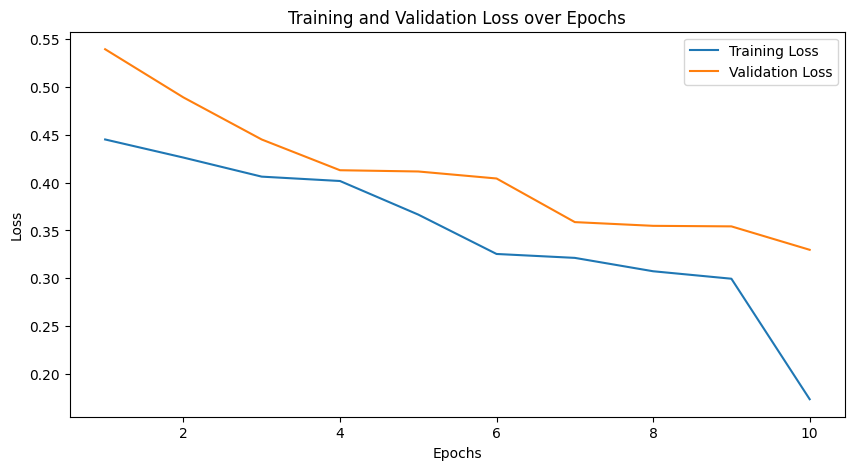

In [ ]:
loss_graph(train_loss_list, validation_loss_list)


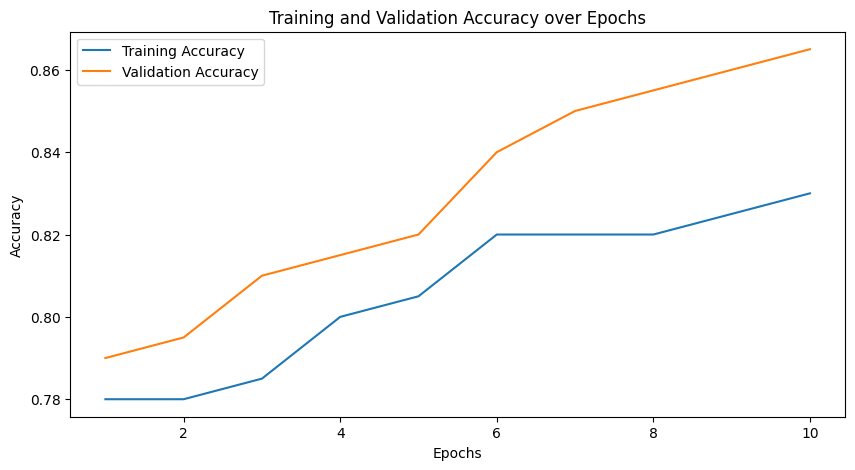

In [ ]:
accuracy_graph(train_accuracy_list, vaccuracy_list)

In [ ]:
model.eval()
true_labels = []
predicted_labels = []

for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted_classes = torch.max(outputs, dim=1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted_classes.cpu().numpy())



In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

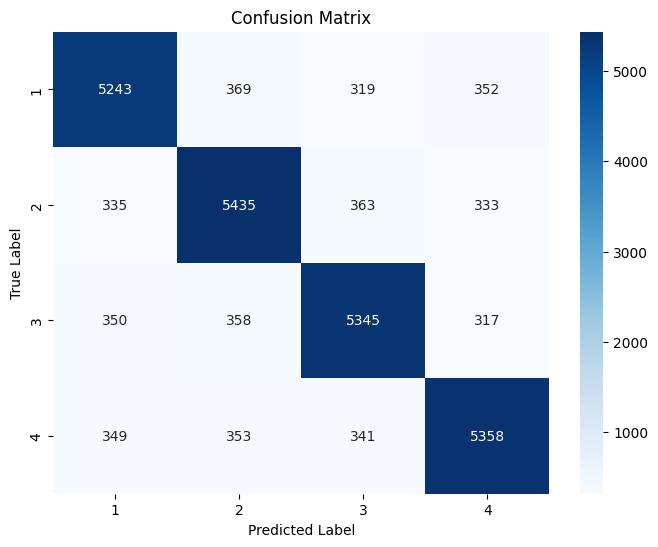

In [ ]:
confusionMatrix(true_labels, predicted_labels)

In [ ]:

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')


Precision: 0.8378265437075882
Recall: 0.8377926853647443
F1 Score: 0.8378044116419412


In [70]:
def multi_class_roc(predictions, test):
    num_classes = 4
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve([1 if label == i else 0 for label in test], [pred for pred in predictions])
        roc_auc = auc(fpr, tpr)

        plt.subplot(2, 2, i + 1)
        plt.plot(fpr, tpr, lw=3, label=f'Class {i} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=3)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC - Class {i}')
        plt.legend(loc='best')
        plt.grid()

    plt.tight_layout()
    plt.show()


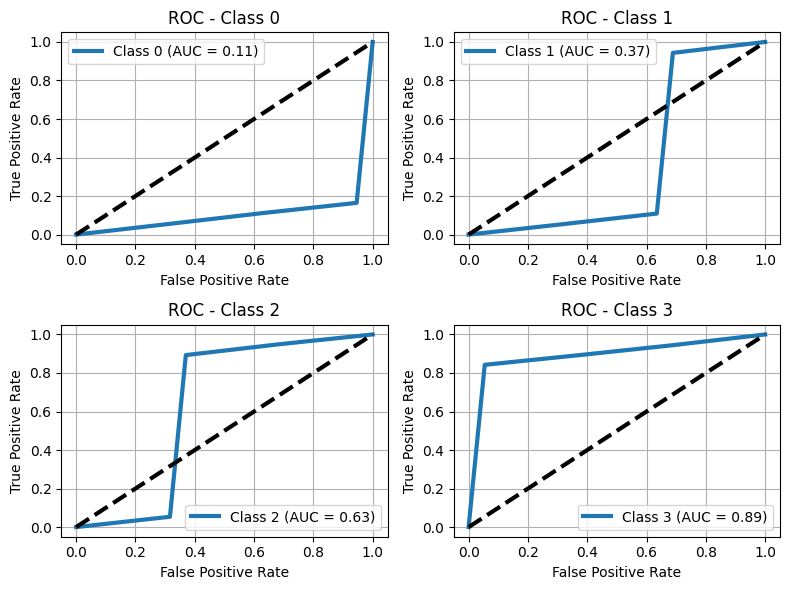

In [ ]:
multi_class_roc(true_labels, predicted_labels)

**Optimization Techniques**

1. Dropout Layer

In [ ]:
class TransformerModelDropout(nn.Module):
    def __init__(self, vocab_size, dimensions, layers, hidden_dimensions,
                 number_of_layers, dropout, output_size):
        super(TransformerModelDropout, self).__init__()

        self.pos_encoder = PositionalEncoding(dimensions, dropout)
        self.dropout = nn.Dropout(dropout)  # Adding dropout layer
        el= nn.TransformerEncoderLayer(dimensions, layers, hidden_dimensions, dropout)
        self.transformer_encoder = nn.TransformerEncoder(el, number_of_layers)
        dl = nn.TransformerDecoderLayer(dimensions, layers, hidden_dimensions, dropout)
        self.transformer_decoder = nn.TransformerDecoder(dl, number_of_layers)
        self.embedding = nn.Embedding(vocab_size, dimensions)
        self.dimensions = dimensions
        self.linear = nn.Linear(dimensions, output_size)
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_mask: torch.Tensor = None, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        src = self.embedding(src) * math.sqrt(self.dimensions)
        src = self.pos_encoder(src)
        src = self.dropout(src)  # Applying dropout
        if src_mask is None:
            src_mask = nn.Transformer.generate_square_subsequent_mask(src.size(0)).to(src.device)
        encoder_output = self.transformer_encoder(src, src_mask)
        decoder_input = encoder_output
        if tgt_mask is None:
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(decoder_input.size(0)).to(decoder_input.device)
        decoder_output = self.transformer_decoder(decoder_input, encoder_output , tgt_mask)
        output = self.linear(decoder_output.squeeze(0))
        return output.mean(dim = 1)


In [ ]:
model = TransformerModelDropout(250, 200, 2, 200, 3, 0.3, 4).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_accuracy_list = []
train_loss_list = []
vaccuracy_list = []
validation_loss_list = []
for epoch in range(10):
    print(f"Epoch {epoch+1}")
    model.train()
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted_classes = torch.max(outputs, dim=1)
        correct_predictions += (predicted_classes == labels).sum().item()
        total_predictions += len(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_accuracy_list.append((correct_predictions)/total_predictions)

    train_loss_list.append(loss.item())
    print(f"Training Loss: {loss}")
    print(f'Training Accuracy: {(correct_predictions)/total_predictions}')
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in valid_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted_classes = torch.max(outputs, dim=1)

            correct_predictions += (predicted_classes == labels).sum().item()
            total_predictions += len(labels)
            loss = criterion(outputs, labels)
        correct_predictions = correct_predictions
        validation_loss_list.append(loss.item())
    vaccuracy_list.append(correct_predictions / total_predictions)
    print(f"Validation Loss: {loss}")
    print(f'Validation Accuracy is {(correct_predictions )/ total_predictions}')
    print('\n')


Epoch 1
Training Loss: 0.5007299184799194
Training Accuracy: 0.6233333333333333
Validation Loss: 0.3584251403808594
Validation Accuracy is 0.62


Epoch 2
Training Loss: 0.2920593023300171
Training Accuracy: 0.6233333333333333
Validation Loss: 0.33880484104156494
Validation Accuracy is 0.6633333333333333


Epoch 3
Training Loss: 0.29135096073150635
Training Accuracy: 0.6166666666666667
Validation Loss: 0.33151495456695557
Validation Accuracy is 0.6233333333333333


Epoch 4
Training Loss: 0.30936622619628906
Training Accuracy: 0.6166666666666667
Validation Loss: 0.4079197645187378
Validation Accuracy is 0.67


Epoch 5
Training Loss: 0.46017372608184814
Training Accuracy: 0.67
Validation Loss: 0.448250412940979
Validation Accuracy is 0.6433333333333333


Epoch 6
Training Loss: 0.40536367893218994
Training Accuracy: 0.57
Validation Loss: 0.35878562927246094
Validation Accuracy is 0.5866666666666667


Epoch 7
Training Loss: 0.3480187654495239
Training Accuracy: 0.6466666666666666
Validation

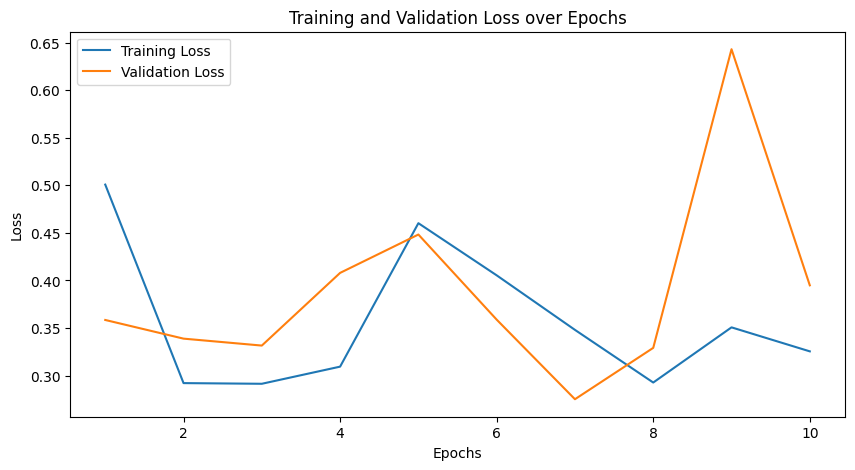

In [ ]:
loss_graph(train_loss_list, validation_loss_list)


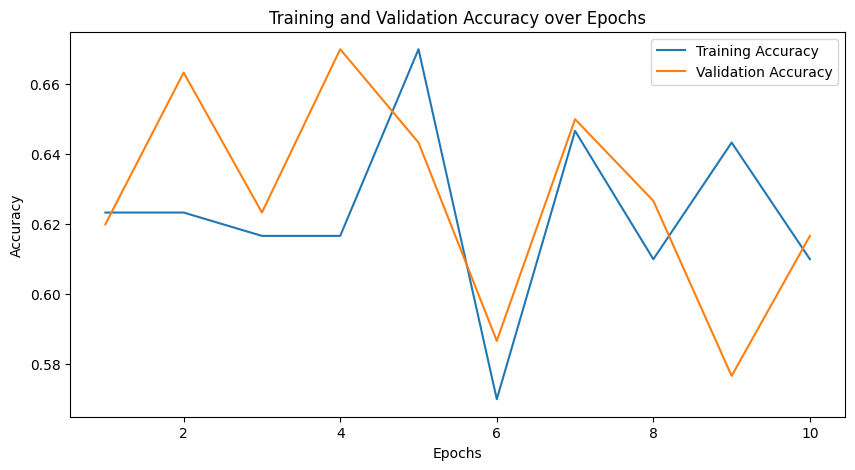

In [ ]:
accuracy_graph(train_accuracy_list, vaccuracy_list)

In [ ]:
model.eval()
true_labels = []
predicted_labels = []

for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted_classes = torch.max(outputs, dim=1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted_classes.cpu().numpy())



In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

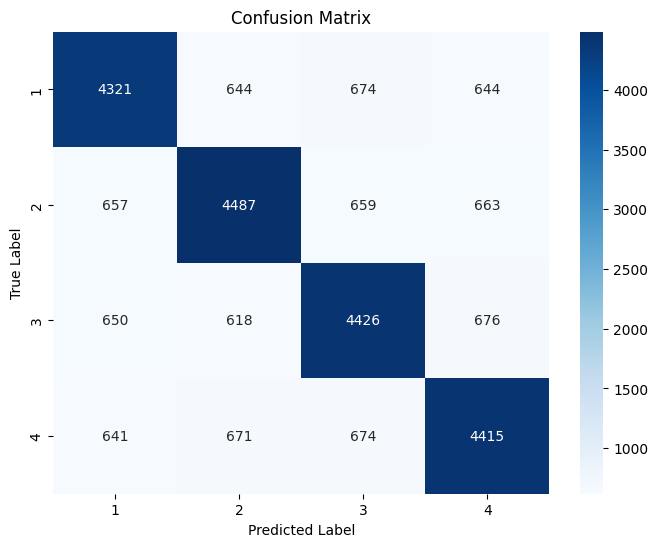

In [ ]:
confusionMatrix(true_labels, predicted_labels)

In [ ]:

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall }')
print(f'F1 Score: {f1_score}')


Precision: 0.5515621523606058
Recall: 0.6915554390779004
F1 Score: 0.6715521680373033


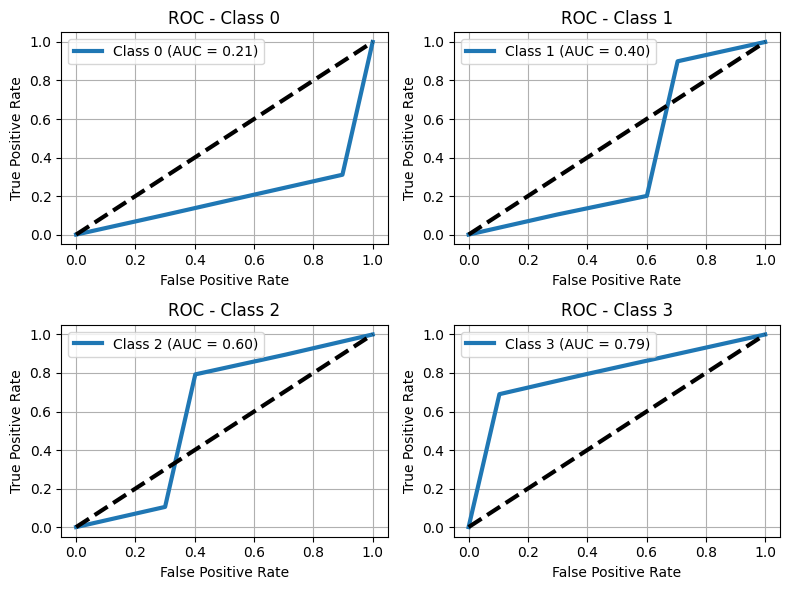

In [ ]:
multi_class_roc(true_labels, predicted_labels)

## 2. Regularization (L1/L2): Penalize large model weights to prevent overfitting


In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_accuracy_list = []
train_loss_list = []
vaccuracy_list = []
validation_loss_list = []

for epoch in range(10):
    print(f"Epoch {epoch+1}")
    model.train()
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted_classes = torch.max(outputs, dim=1)
        correct_predictions += (predicted_classes == labels).sum().item()
        total_predictions += len(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        l1_lambda = 0.001  # Example L1 penalty
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm
        optimizer.step()
    train_accuracy_list.append((correct_predictions)/total_predictions)

    train_loss_list.append(loss.item())
    print(f"Training Loss: {loss}")
    print(f'Training Accuracy: {(correct_predictions)/total_predictions}')

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in valid_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted_classes = torch.max(outputs, dim=1)

            correct_predictions += (predicted_classes == labels).sum().item()
            total_predictions += len(labels)
            loss = criterion(outputs, labels)
        validation_loss_list.append(loss.item())
    vaccuracy_list.append(correct_predictions / total_predictions)


    print(f"Validation Loss: {loss}")
    print(f'Validation Accuracy is {(correct_predictions )/ total_predictions}')
    print('\n')


Epoch 1
Training Loss: 129.81346130371094
Training Accuracy: 0.58
Validation Loss: 0.21563208103179932
Validation Accuracy is 0.6566666666666666


Epoch 2
Training Loss: 132.16766357421875
Training Accuracy: 0.6366666666666667
Validation Loss: 0.3875703811645508
Validation Accuracy is 0.6433333333333333


Epoch 3
Training Loss: 136.3086700439453
Training Accuracy: 0.6133333333333333
Validation Loss: 0.4344048500061035
Validation Accuracy is 0.6166666666666667


Epoch 4
Training Loss: 142.28097534179688
Training Accuracy: 0.6133333333333333
Validation Loss: 0.4009362459182739
Validation Accuracy is 0.6433333333333333


Epoch 5
Training Loss: 143.45484924316406
Training Accuracy: 0.6633333333333333
Validation Loss: 0.4341975450515747
Validation Accuracy is 0.6233333333333333


Epoch 6
Training Loss: 149.98777770996094
Training Accuracy: 0.6666666666666666
Validation Loss: 0.42064476013183594
Validation Accuracy is 0.6233333333333333


Epoch 7
Training Loss: 157.24391174316406
Training Ac

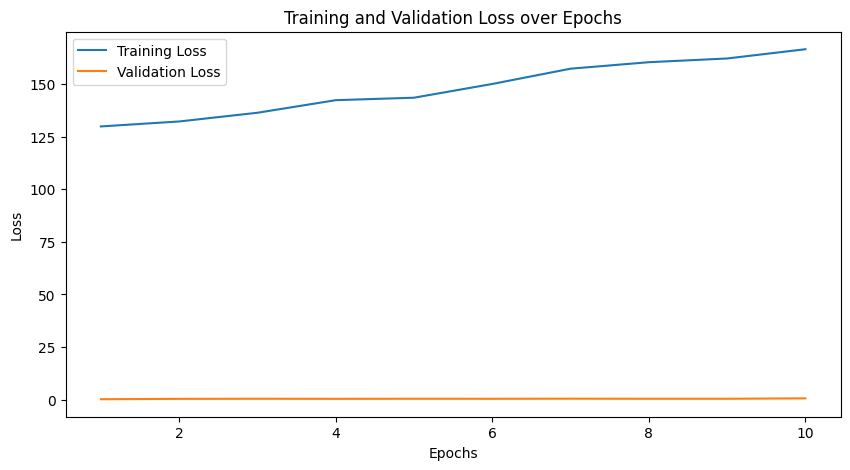

In [62]:
loss_graph(train_loss_list, validation_loss_list)


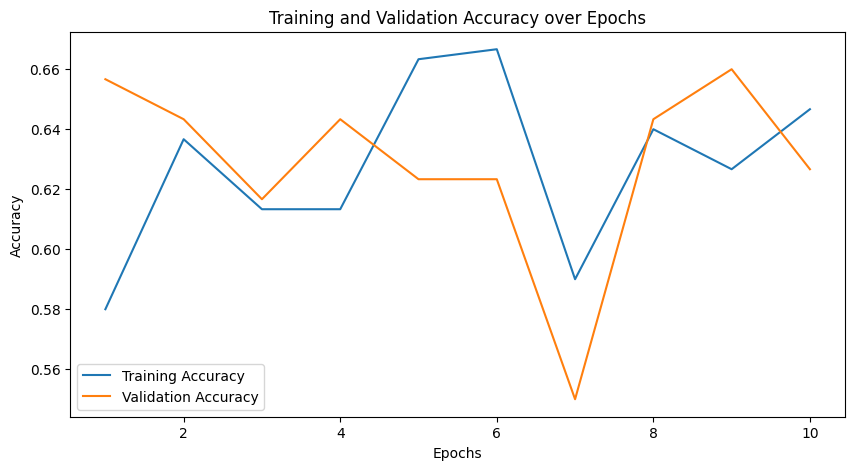

In [63]:
accuracy_graph(train_accuracy_list, vaccuracy_list)

In [64]:
model.eval()
true_labels = []
predicted_labels = []

for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted_classes = torch.max(outputs, dim=1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted_classes.cpu().numpy())



In [66]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

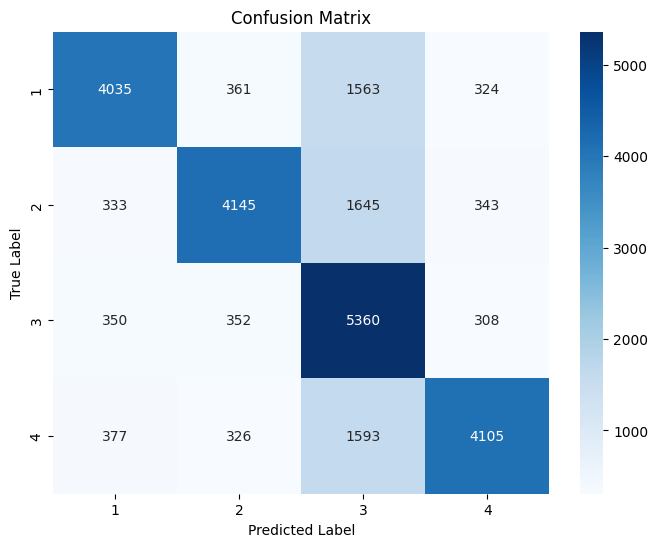

In [67]:
confusionMatrix(true_labels, predicted_labels)

In [68]:

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall }')
print(f'F1 Score: {f1_score}')


Precision: 0.731776628386318
Recall: 0.6915012300785507
F1 Score: 0.6961061484192075


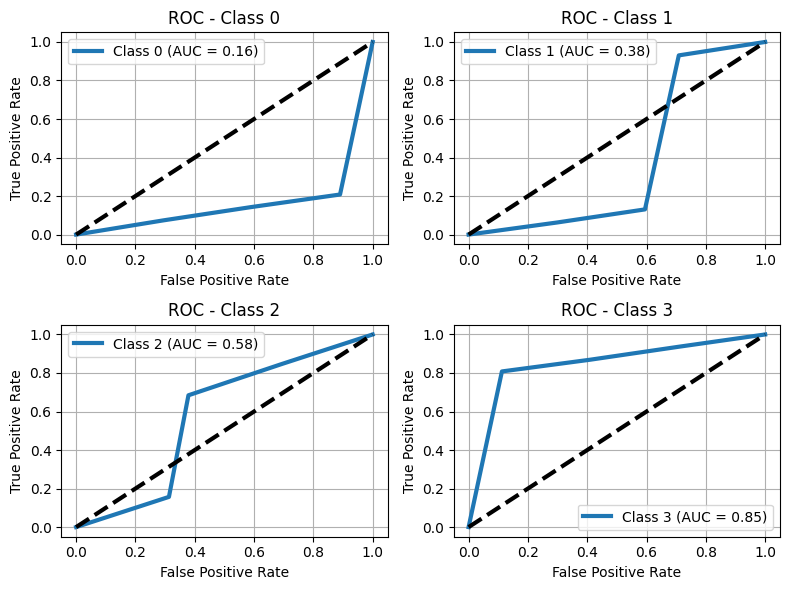

In [71]:
multi_class_roc(true_labels, predicted_labels)

## Different Learning Rates

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
train_accuracy_list = []
train_loss_list = []
vaccuracy_list = []
validation_loss_list = []
for epoch in range(10):
    print(f"Epoch {epoch+1}")
    model.train()

    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted_classes = torch.max(outputs, dim=1)
        correct_predictions += (predicted_classes == labels).sum().item()
        total_predictions += len(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_accuracy_list.append((correct_predictions)/total_predictions)

    train_loss_list.append(loss.item())
    print(f'Training Accuracy: {(correct_predictions)/total_predictions}')
    print(f"Training Loss: {loss}")

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in valid_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted_classes = torch.max(outputs, dim=1)

            correct_predictions += (predicted_classes == labels).sum().item()
            total_predictions += len(labels)
            loss = criterion(outputs, labels)

        validation_loss_list.append(loss.item())
    vaccuracy_list.append(correct_predictions / total_predictions)


    print(f"Validation Loss: {loss}")
    print(f'Validation Accuracy is {(correct_predictions )/ total_predictions}')
    print('\n')


Epoch 1
Training Accuracy: 0.6133333333333333
Training Loss: 0.29749786853790283
Validation Loss: 1.0644614696502686
Validation Accuracy is 0.61


Epoch 2
Training Accuracy: 0.63
Training Loss: 1.067896842956543
Validation Loss: 0.8386034965515137
Validation Accuracy is 0.61


Epoch 3
Training Accuracy: 0.6166666666666667
Training Loss: 0.7091764211654663
Validation Loss: 0.17343056201934814
Validation Accuracy is 0.5833333333333334


Epoch 4
Training Accuracy: 0.66
Training Loss: 0.7173446416854858
Validation Loss: 0.3154648542404175
Validation Accuracy is 0.63


Epoch 5
Training Accuracy: 0.6133333333333333
Training Loss: 0.7565826177597046
Validation Loss: 0.266414999961853
Validation Accuracy is 0.56


Epoch 6
Training Accuracy: 0.5933333333333334
Training Loss: 0.2850494384765625
Validation Loss: 0.2770458459854126
Validation Accuracy is 0.6066666666666667


Epoch 7
Training Accuracy: 0.62
Training Loss: 0.4335881471633911
Validation Loss: 0.5913190841674805
Validation Accuracy is

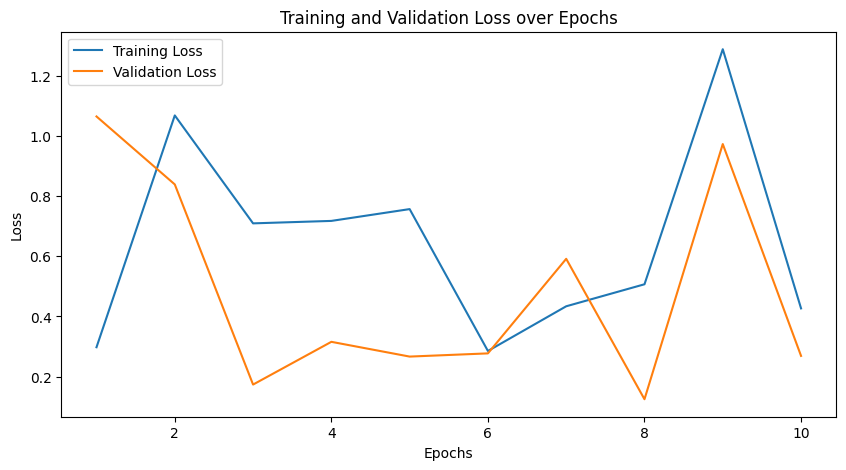

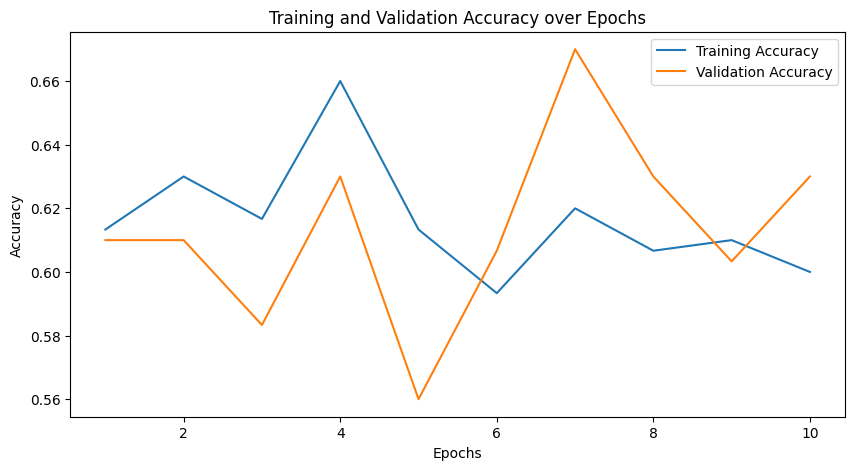

In [74]:
loss_graph(train_loss_list, validation_loss_list)
accuracy_graph(train_accuracy_list, vaccuracy_list)

In [75]:
model.eval()
true_labels = []
predicted_labels = []

for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted_classes = torch.max(outputs, dim=1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted_classes.cpu().numpy())



In [77]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

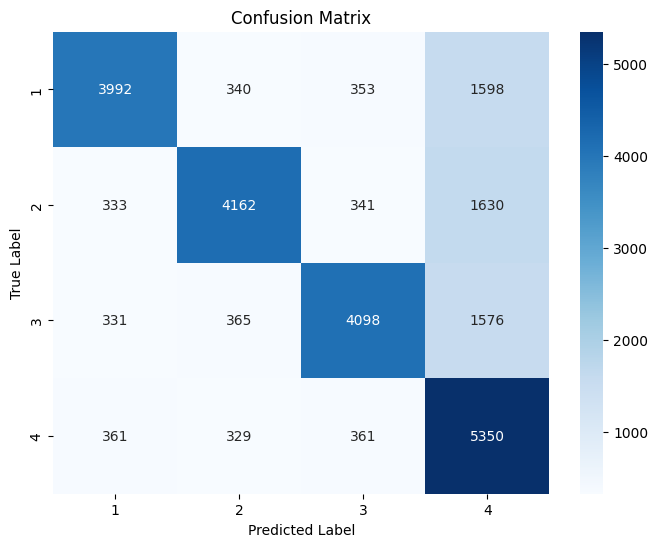

In [78]:
confusionMatrix(true_labels, predicted_labels)

In [79]:

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall }')
print(f'F1 Score: {f1_score}')


Precision: 0.729711564640679
Recall: 0.6895437206596631
F1 Score: 0.6944808537688647


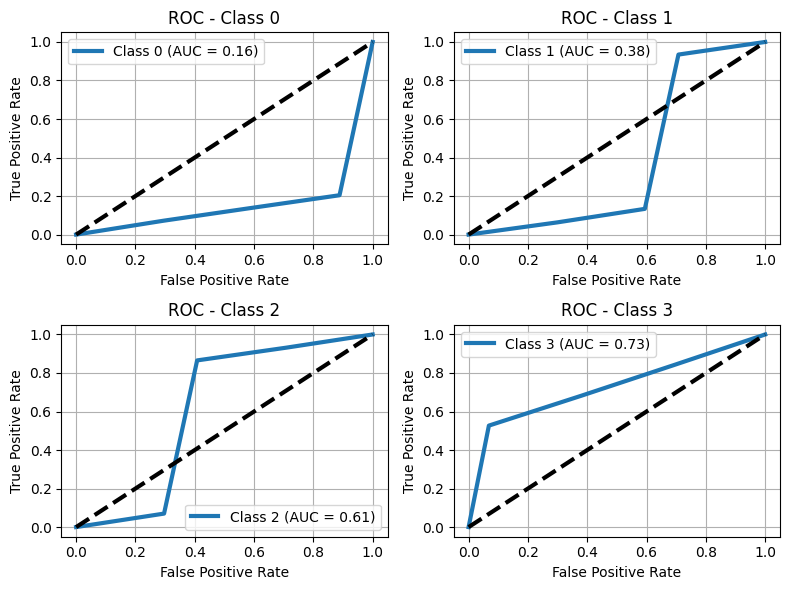

In [80]:
multi_class_roc(true_labels, predicted_labels)

4. Another Learning Rate

In [80]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_accuracy_list = []
train_loss_list = []
vaccuracy_list = []
validation_loss_list = []
for epoch in range(10):
    print(f"Epoch {epoch+1}")
    model.train()
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted_classes = torch.max(outputs, dim=1)
        correct_predictions += (predicted_classes == labels).sum().item()
        total_predictions += len(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    train_accuracy_list.append((correct_predictions)/total_predictions)

    train_loss_list.append(loss.item() )
    print(f'Training Accuracy: {(correct_predictions)/total_predictions}')
    print(f"Training Loss: {loss}")
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in valid_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted_classes = torch.max(outputs, dim=1)

            correct_predictions += (predicted_classes == labels).sum().item()
            total_predictions += len(labels)
            loss = criterion(outputs, labels)

        validation_loss_list.append(loss.item())
    vaccuracy_list.append(correct_predictions / total_predictions)


    print(f"Validation Loss: {loss}")
    print(f'Validation Accuracy is {(correct_predictions )/ total_predictions}')
    print('\n')


In [80]:
loss_graph(train_loss_list, validation_loss_list)
accuracy_graph(train_accuracy_list, vaccuracy_list)

In [81]:
model.eval()
true_labels = []
predicted_labels = []

for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted_classes = torch.max(outputs, dim=1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted_classes.cpu().numpy())



In [83]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

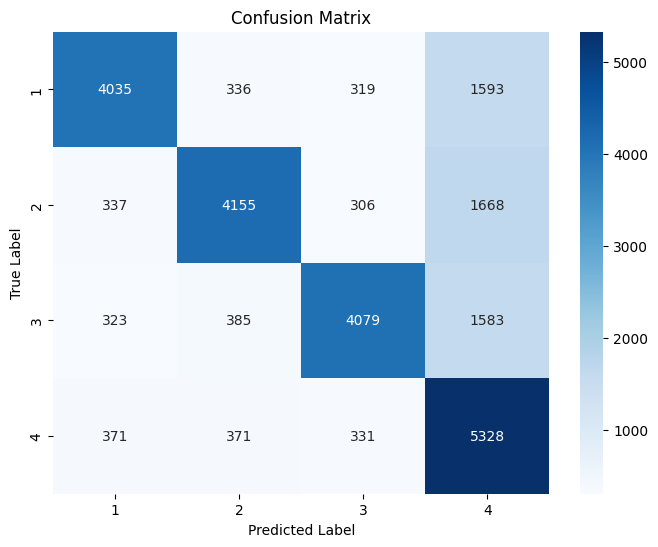

In [84]:
confusionMatrix(true_labels, predicted_labels)

In [85]:

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall }')
print(f'F1 Score: {f1_score}')


Precision: 0.7305718373205593
Recall: 0.6893791166680887
F1 Score: 0.6947044490210867


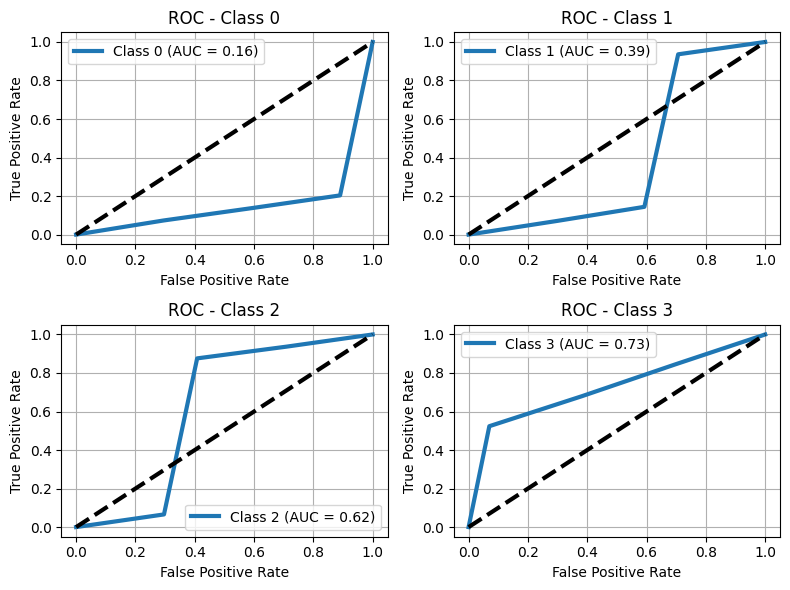

In [86]:
multi_class_roc(true_labels, predicted_labels)

## References


Part 4 is based on the CSE 574 Machine Learning Assignment 2 submission by
Yashwanth Chennu

https://pytorch.org/tutorials/beginner/transformer_tutorial.html